# DID analysis about VADER scores of submissions

## Install and import packages

In [44]:
%pip install pandas vaderSentiment statsmodels matplotlib seaborn

import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols

Note: you may need to restart the kernel to use updated packages.


## Parameters

In [45]:
# パスの設定
treatment_path = './submissions_Palestine_Israel_IsraelPalestine_20241026_173259.csv'
control_path = './submissions_ps4homebrew_Exercise_voyageons_20241026_173008.csv'

# VADERの初期化
analyzer = SentimentIntensityAnalyzer()

## Load data

In [47]:
# Load CSV files
treatment_df = pd.read_csv('./submissions_Palestine_Israel_IsraelPalestine_20241026_173259.csv')
control_df = pd.read_csv('./submissions_ps4homebrew_Exercise_voyageons_20241026_173008.csv')

# Display basic information about the datasets to understand their structure
treatment_df.info(), control_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2713 non-null   object
 1   title        2713 non-null   object
 2   created_utc  2713 non-null   object
 3   score        2713 non-null   int64 
 4   url          2713 non-null   object
 5   text         1593 non-null   object
dtypes: int64(1), object(5)
memory usage: 127.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1740 entries, 0 to 1739
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1740 non-null   object
 1   title        1740 non-null   object
 2   created_utc  1740 non-null   object
 3   score        1740 non-null   int64 
 4   url          1740 non-null   object
 5   text         1588 non-null   object
dtypes: int64(1), object(5)
memory usage: 81.7+ KB


(None, None)

## Calculates VADER scores

In [49]:
# Function to calculate VADER score
def calculate_vader_score(text):
    text = str(text)
    return analyzer.polarity_scores(text)['compound']

# Calculate VADER scores for each text entry
treatment_df['vader_score'] = treatment_df['text'].apply(calculate_vader_score)
control_df['vader_score'] = control_df['text'].apply(calculate_vader_score)

## Grouping data into treatment or control

In [67]:
# Convert 'created_utc' to datetime and create treatment/control dummy variables
treatment_df['created_utc'] = pd.to_datetime(treatment_df['created_utc'], utc=True)
control_df['created_utc'] = pd.to_datetime(control_df['created_utc'], utc=True)

# Calculate average VADER scores for each day
treatment_daily_avg = treatment_df.groupby('created_utc')['vader_score'].mean().reset_index()
control_daily_avg = control_df.groupby('created_utc')['vader_score'].mean().reset_index()

# Add a treatment indicator
treatment_daily_avg['treatment'] = 1
control_daily_avg['treatment'] = 0

# Combine treatment and control data
combined_df = pd.concat([treatment_daily_avg, control_daily_avg])

# Create a binary variable for pre- and post- October 1, 2024
cutoff_date = pd.to_datetime('2024-10-01', utc=True)
combined_df['post_treatment'] = (combined_df['created_utc'] >= cutoff_date).astype(int)

# Group by day to count number of submissions per day for each group
combined_df['date'] = combined_df['created_utc'].dt.date
daily_avg_scores = combined_df.groupby(['date', 'treatment', 'post_treatment', 'vader_score']).size().reset_index(name='submission_count')

# Display the resulting daily submission counts
daily_avg_scores.head()

,date,treatment,post_treatment,vader_score,submission_count
0,2024-07-28,0,0,0.3400,1
1,2024-07-28,0,0,0.4215,1
2,2024-07-28,1,0,-0.9979,1
3,2024-07-28,1,0,-0.9597,1
4,2024-07-28,1,0,0.2589,1


## Create model and output summary

In [70]:
import statsmodels.formula.api as smf

# Fit the DID model
daily_avg_scores['interaction'] = daily_avg_scores['treatment'] * daily_avg_scores['post_treatment']
model_weighted = smf.wls('vader_score ~ treatment + post_treatment + interaction', data=daily_avg_scores, weights=daily_avg_scores['submission_count']).fit()
print(model_weighted.summary())

                            WLS Regression Results                            
Dep. Variable:            vader_score   R-squared:                       0.066
Model:                            WLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     68.08
Date:                Sat, 26 Oct 2024   Prob (F-statistic):           1.57e-42
Time:                        19:10:57   Log-Likelihood:                -2925.7
No. Observations:                2881   AIC:                             5859.
Df Residuals:                    2877   BIC:                             5883.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2011      0.020      9.

## Visualization

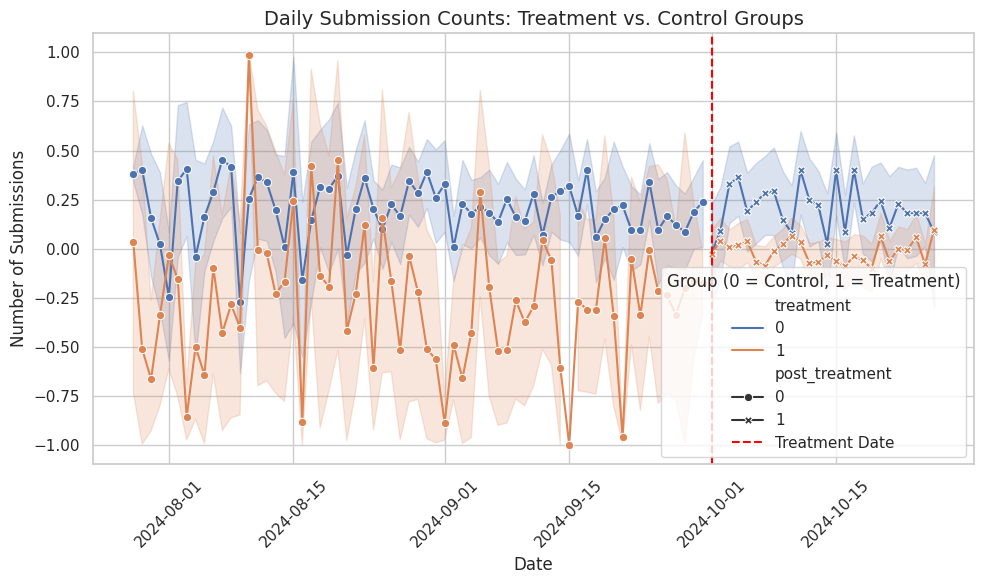

In [71]:
# Set plot style
sns.set(style="whitegrid")

# Plot daily submission counts for treatment and control groups, before and after the treatment date
plt.figure(figsize=(10, 6))

# Plot submission counts over time for treatment and control groups
sns.lineplot(data=combined_df, x='date', y='vader_score', hue='treatment', style='post_treatment', markers=True, dashes=False)

# Add vertical line indicating the treatment date
plt.axvline(pd.to_datetime('2024-10-01'), color='red', linestyle='--', label='Treatment Date')

# Labels and title
plt.title('Daily Submission Counts: Treatment vs. Control Groups', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Submissions', fontsize=12)
plt.legend(title='Group (0 = Control, 1 = Treatment)')
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()
